# Problem Set 4

## Logistic Regression, Classification & Regularization

### Prem Shah

### INFX 574

This problem set uses the Wisconsin Breast Cancer Dataset and the below, we see the description of the attributes.

* a) radius (mean of distances from center to points on the perimeter)
* b) texture (standard deviation of gray-scale values)
* c) perimeter
* d) area
* e) smoothness (local variation in radius lengths)
* f) compactness (perimeter^2 / area - 1.0)
* g) concavity (severity of concave portions of the contour)
* h) concave points (number of concave portions of the contour)
* i) symmetry 
* j) fractal dimension ("coastline approximation" - 1)

Each feature has its mean, standard error and the worst of the largest three values, which results in 30 features as we can see in the below output

### Collaborators: Aditya Wakade, Gaurav Gohil, Pratik Damania, Manasi Kulkarni

In [100]:
#Importing Libraries
import pandas as pd
from collections import OrderedDict
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.cross_validation import train_test_split,cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,auc
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from random import seed,randrange
from sklearn.decomposition import PCA

## 1. Explore the data
### 1.1 Load the data

Here, we load the data and also adrop id column and convert diagnosis into a categorical variable

In [34]:
data = pd.read_csv("wdbc.csv.bz2")
data.head(5)

id diagnosis  radius.mean  texture.mean  perimeter.mean  area.mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness.mean  compactness.mean  concavity.mean  concpoints.mean  \
0          0.11840           0.27760          0.3001          0.14710   
1          0.08474           0.07864          0.0869          0.07017   
2          0.10960           0.15990          0.1974          0.12790   
3          0.14250           0.28390          0.2414          0.10520   
4          0.10030           0.13280          0.1980          0.10430   

       ...        radius.worst  texture.worst  perimeter.worst  area.worst  \
0      ...               25.38          17.33           184.60      2019.0   
1      ...               24.99          23.41           158.80      1956.0   
2      ...               23.57          25.53           152.50      1709.0   
3      ...               14.91          26.50            98.87       567.7   
4      ...               22.54          16.67           152.20      1575.0   

   smoothness.worst  compactness.worst  concavity.worst  concpoints.worst  \
0            0.1622             0.6656           0.7119            0.2654   
1            0.1238             0.1866           0.2416            0.1860   
2            0.1444             0.4245           0.4504            0.2430   
3            0.2098             0.8663           0.6869            0.2575   
4            0.1374             0.2050           0.4000            0.1625   

   symmetry.worst  fracdim.worst  
0          0.4601        0.11890  
1          0.2750        0.08902  
2          0.3613        0.08758  
3          0.6638        0.17300  
4          0.2364        0.07678  

[5 rows x 32 columns]

In [35]:
#Dropping the ID Column
data = data.drop('id',axis=1)

In [36]:
#Use label encoder function for converting string into categorical data
label_encoder = LabelEncoder()
label_encoder.fit(data['diagnosis']) 
data['diagnosis'] = label_encoder.transform(data['diagnosis'])

In [37]:
data['diagnosis'].unique()

array([1, 0], dtype=int64)

### 1.2 Summary statistics

Calculate mean, stdev and correlation for the variables

In [6]:
def summary_statistics(data):
    #Calculate summary statistics of the data
    summary = data.describe()
    missing_values = pd.isnull(data).sum(axis=0)
    idx2 = pd.Index(['year','folnum','village'])

    #Remove variables not needed in summary statistics
    columns = summary.columns
    summary = summary[columns].T

    #Extract mean and standard deviation
    mean = summary['mean']
    std = summary['std']
    data_range = summary['max'] - summary['min']
    correlation = data.corr()['diagnosis']

    #Print the summary statistics
    summary_mean_std = pd.concat([mean,std,data_range,missing_values,correlation],axis=1)
    summary_mean_std.columns = ['mean','std','range','missing values',"correlation"]
    return summary_mean_std

In [7]:
#Print summary statistics
summary = summary_statistics(data)

In [8]:
#Print a subset of summary statistics
summary.head(10)

mean         std       range  missing values  \
diagnosis           0.372583    0.483918     1.00000               0   
radius.mean        14.127292    3.524049    21.12900               0   
texture.mean       19.289649    4.301036    29.57000               0   
perimeter.mean     91.969033   24.298981   144.71000               0   
area.mean         654.889104  351.914129  2357.50000               0   
smoothness.mean     0.096360    0.014064     0.11077               0   
compactness.mean    0.104341    0.052813     0.32602               0   
concavity.mean      0.088799    0.079720     0.42680               0   
concpoints.mean     0.048919    0.038803     0.20120               0   
symmetry.mean       0.181162    0.027414     0.19800               0   

                  correlation  
diagnosis            1.000000  
radius.mean          0.730029  
texture.mean         0.415185  
perimeter.mean       0.742636  
area.mean            0.708984  
smoothness.mean      0.358560  
compactness.mean     0.596534  
concavity.mean       0.696360  
concpoints.mean      0.776614  
symmetry.mean        0.330499

### 1.3 Scatterplot matrix

In [9]:
summary[summary.correlation < 0]

mean       std     range  missing values  correlation
fracdim.mean   0.062798  0.007060  0.047480               0    -0.012838
texture.se     1.216853  0.551648  4.524800               0    -0.008303
smoothness.se  0.007041  0.003003  0.029417               0    -0.067016
symmetry.se    0.020542  0.008266  0.071068               0    -0.006522

In [10]:
summary[summary.correlation > 0.77]

mean        std     range  missing values  correlation
diagnosis           0.372583   0.483918    1.0000               0     1.000000
concpoints.mean     0.048919   0.038803    0.2012               0     0.776614
radius.worst       16.269190   4.833242   28.1100               0     0.776454
perimeter.worst   107.261213  33.602542  200.7900               0     0.782914
concpoints.worst    0.114606   0.065732    0.2910               0     0.793566

From the above results, we see that the highest correlation exists between concpoints.mean, radius.worst, perimeter.worst with the diagnosis

#### 1.3.1 Graphical Exploration

In [11]:
#Parameters for the graphs
temp_data = data[['perimeter.worst','concpoints.worst','concpoints.mean','radius.worst']]
highly_correlated_features = ['perimeter.worst','concpoints.worst','concpoints.mean','radius.worst']
color_dic = {1:'red', 0:'green'}
colors = data['diagnosis'].map(lambda x: color_dic.get(x))

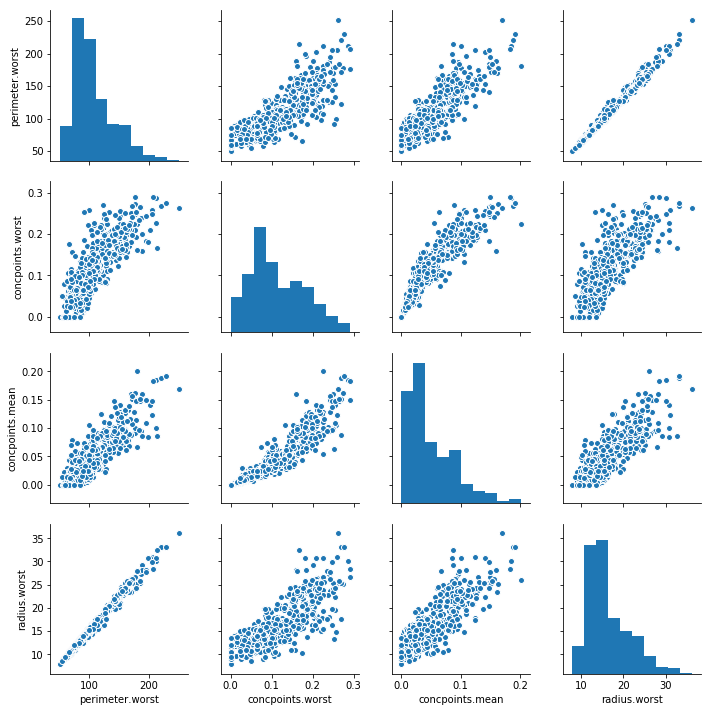

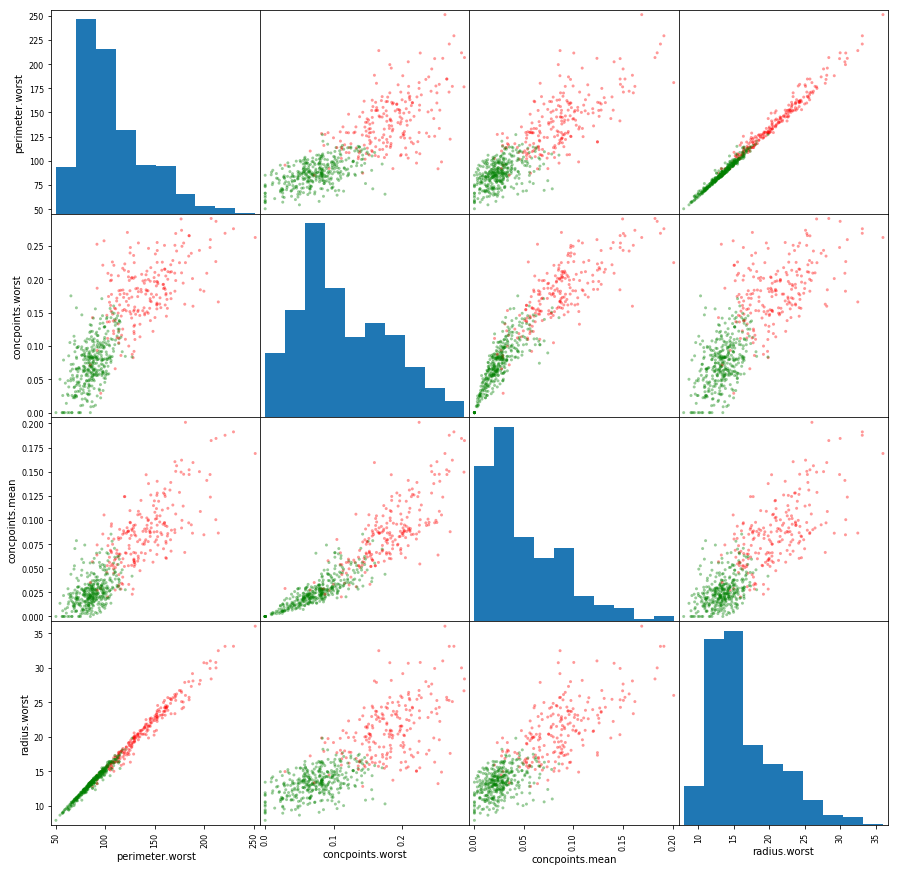

In [14]:
sns.pairplot(temp_data)
sm = pd.plotting.scatter_matrix(data[highly_correlated_features], c=colors, alpha=0.4, figsize=((15,15)));

plt.show()

Here, the green portion on the scatterplot indicates benign classification while the red one indicates malignant classification. We observe that most of the benign tumors have lesser values than the malignant tumors.

## 2. Decision boundary

We predict the classes and make a contour plot for the same in order to plot a decision boundary. 



### 2.1 kNN Case

For the kNN case, we will pick two higly correlated features in order to make the decision boundary:

* concpoints.worst
* concpoints.mean

#### 2.1.1 Predictions
We first divide the dataset into training and testing. 

NOTE: The selected variables do not vary much in scale

In [251]:
#Define the output variable
y = data['diagnosis']
#defining the input parameters
X = data

#Remove output variable and id from input parameters dataframe
columns = list(X.columns)
columns.remove('diagnosis')
X = X[columns]

In [186]:
#Splot into training and testing data
x_train, x_test, y_train, y_test = train_test_split(X,y)

In [187]:
#Define the model
knn_model = KNeighborsClassifier(n_neighbors=6)

Now, we select two highly correlated parameters as mentioned above for training the model.   

In [194]:
#Fit the data
knn_model.fit(x_train[['concpoints.mean','concpoints.worst']],y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=6, p=2,
           weights='uniform')

In [195]:
predictions_all = knn_model.predict(x_test[['concpoints.mean','concpoints.worst']])

#Accuracy score
accuracy_score(predictions_all,y_test)*100

90.20979020979021

#### 2.1.2 Plotting the decision boundaries

Here, we first define some parameters for the contour plots and then plot them.

In [196]:
#Parameters for the plots
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
cmap_bold = ListedColormap([ '#00FF00','#FF0000'])

#Defining minimum and maximum values
x_min, x_max = X['concpoints.mean'].min() - 0.1, X['concpoints.mean'].max() + 0.1
y_min, y_max = X['concpoints.worst'].min() - 0.005, X['concpoints.worst'].max() + 0.005
h=0.001

In [197]:
#Defining the matrix
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
xy_mesh=np.c_[xx.ravel(),yy.ravel()]
Z=knn_model.predict(xy_mesh)
Z = Z.reshape(xx.shape)
print(np.shape(Z))

(302, 402)


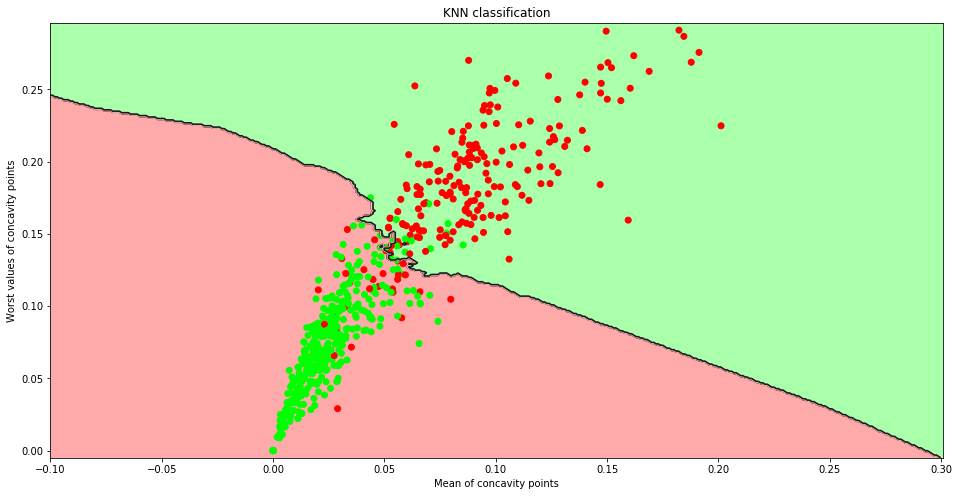

In [198]:
plt.figure(figsize=(16,8))
plt.pcolormesh(xx,yy,Z,cmap=cmap_light)
plt.contour(xx,yy,Z,cmap=plt.cm.RdGy)
ax=plt.scatter(X['concpoints.mean'],X['concpoints.worst'],c=y,cmap=cmap_bold)
#PLotting parameters
plt.xlim(xx.min(),xx.max())
plt.ylim(yy.min(),yy.max())
plt.xlabel('Mean of concavity points')
plt.ylabel('Worst values of concavity points')
plt.title('KNN classification')
plt.show()

#### 2.1.3 Observations

Here, we see that the kNN model with value of k equal to 6 can pick up noise pretty well but it still fails in some cases. It picks up a good actual shape as far as a basic model is concerned

### 2.2 Logistic Regression

Same process for Logistic Regression

#### 2.2.1 Fitting a model & Prediction

In [199]:
#Logistic Regression model
log=LogisticRegression(C=1000)
log.fit(x_train[['concpoints.mean','concpoints.worst']],y_train)

#Define matrix
Z = log.predict(xy_mesh)
Z = Z.reshape(xx.shape)

#### 2.2.2 Predicting the diagnosis

In [200]:
predictions_all = log.predict(x_test[['concpoints.mean','concpoints.worst']])

#Accuracy score
accuracy_score(predictions_all,y_test)

0.916083916083916

#### 2.2.3 Plotting the results

c:\users\iguest\appdata\local\programs\python\python36\lib\site-packages\matplotlib\contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


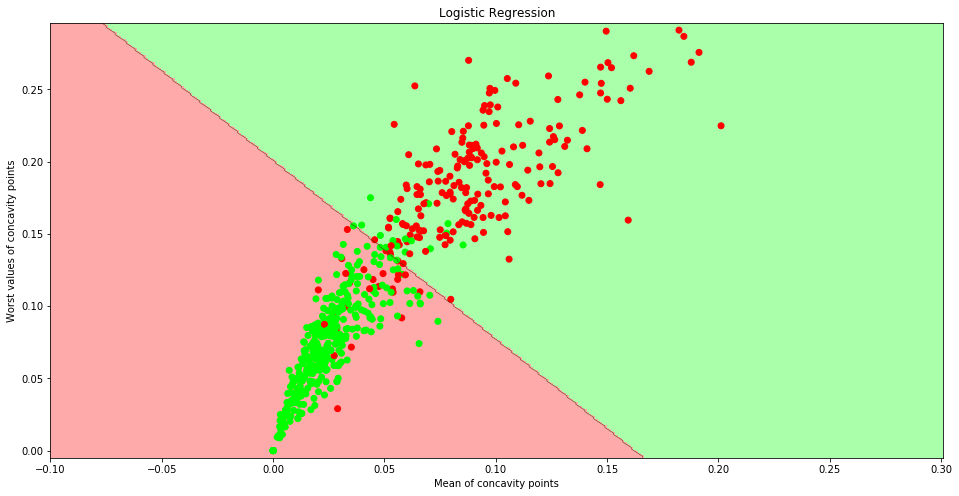

In [201]:
plt.figure(figsize=(16,8))
plt.pcolormesh(xx,yy,Z,cmap=cmap_light)
plt.contour(xx,yy,Z, linewidths = 0.5, levels = 1, cmap = plt.cm.BrBG)
ax=plt.scatter(X['concpoints.mean'],X['concpoints.worst'],c=y,cmap=cmap_bold)
plt.xlim(xx.min(),xx.max())
plt.ylim(yy.min(),yy.max())
plt.xlabel('Mean of concavity points')
plt.ylabel('Worst values of concavity points')
plt.title('Logistic Regression')
plt.show()

#### 2.2.4 Observations

The Logistic Regression model performs better than knn where n=6

### 2.3 Feature Engineering

Here, we create two features, one being logx*y, x2*y2, logy

In [202]:
data_new = data

#Define the output variable
y = data_new['diagnosis']
#defining the input parameters
X = data_new

#Remove output variable and id from input parameters dataframe
columns = list(X.columns)
columns.remove('diagnosis')
X = X[columns]

In [217]:
#X['logx_y'] = X['concpoints.worst']*np.log(X['concpoints.mean'])
X['x2y2'] = (X['concpoints.mean']**2)*(X['concpoints.worst']**2)
X['xy'] = (X['concpoints.mean']**1)*(X['concpoints.worst']**1)
X['x3'] = X['concpoints.mean']**3

0.916083916083916


c:\users\iguest\appdata\local\programs\python\python36\lib\site-packages\matplotlib\contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


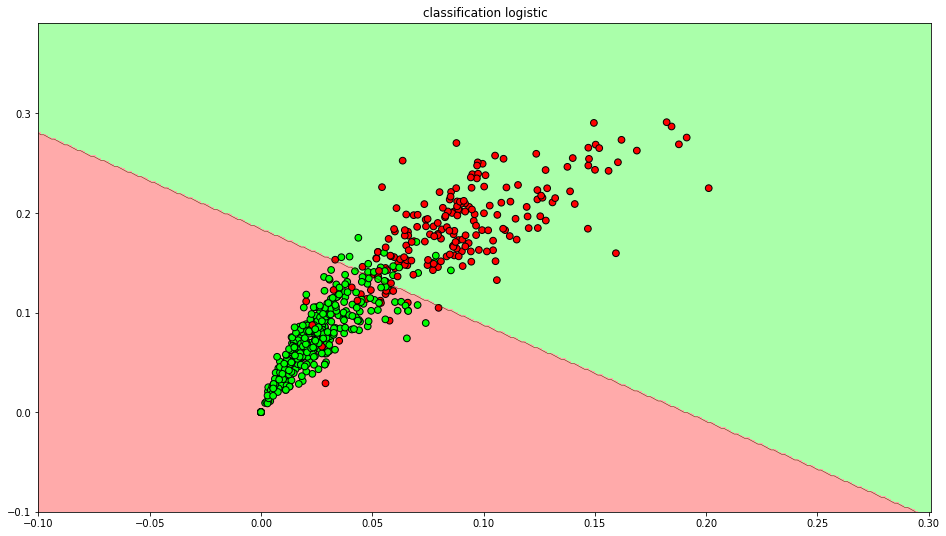

In [218]:
X = X[['concpoints.mean','concpoints.worst','x2y2','x3']]
x_train, x_test, y_train, y_test = train_test_split(X,y)
#log.fit(x_train,y_train)
log=LogisticRegression(C=1000,tol=1e-12,solver="lbfgs")
#log.fit(x_train, y_train)
log.fit(x_train, y_train)
# Plotting decision regions
#x_min, x_max = x[a].min(), x[a].max()
#y_min, y_max = x[b].min(), x[b].max()
x_min, x_max = X['concpoints.mean'].min() - 0.1, X['concpoints.mean'].max() + 0.1
y_min, y_max = X['concpoints.worst'].min() - 0.1, X['concpoints.worst'].max() + 0.1

z_min, z_max = X['x2y2'].min(), X['x2y2'].max()
u_min, u_max = X['x3'].min(), X['x3'].max()


xx, zz = np.meshgrid(np.linspace(x_min, x_max, 341),np.linspace(z_min, z_max, 341))

xx, uu = np.meshgrid(np.linspace(x_min, x_max, 341),np.linspace(u_min, u_max, 341))

#xx, yy = np.meshgrid(np.linspace(x_min, x_max, 341),np.linspace(y_min, y_max, 341))

Z = log.predict(np.c_[xx.ravel(), yy.ravel(), zz.ravel(), uu.ravel()])
z1 = Z.reshape(xx.shape)

print(accuracy_score(log.predict(x_test),y_test))

plt.figure(figsize=(16,9))
plt.pcolormesh(xx, yy, z1, cmap=cmap_light)
plt.contour(xx,yy,z1, linewidths = 0.5, levels = 1, cmap = plt.cm.BrBG)
plt.scatter(X['concpoints.mean'], X['concpoints.worst'], c=y, cmap=cmap_bold, edgecolor='k', s=45)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("classification logistic")
plt.show()

0.9230769230769231


c:\users\iguest\appdata\local\programs\python\python36\lib\site-packages\matplotlib\contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


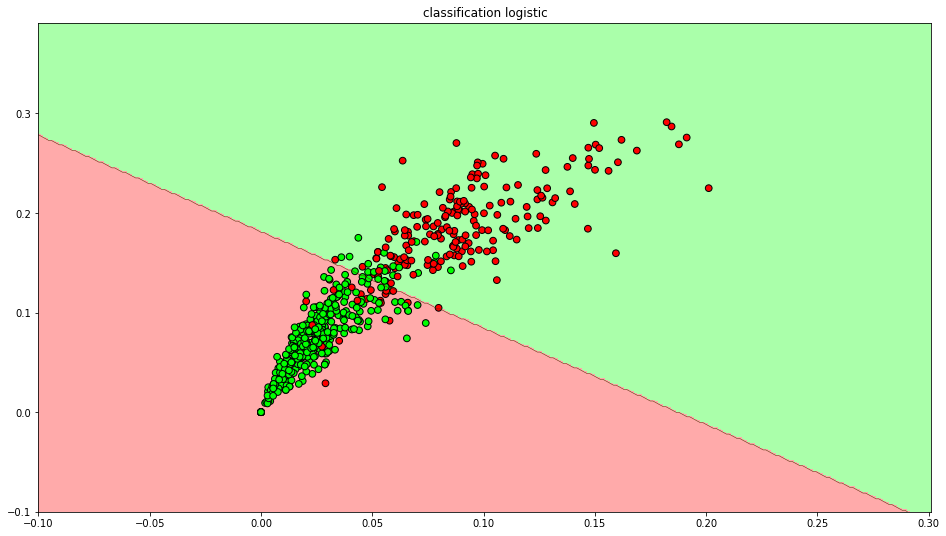

In [215]:
X['x2y2'] = (X['concpoints.mean']**2)*(X['concpoints.worst']**2)
X['xy'] = (X['concpoints.mean']**1)*(X['concpoints.worst']**1)
X['x3'] = X['concpoints.mean']**3

X = X[['concpoints.mean','concpoints.worst','xy','x2y2']]
x_train, x_test, y_train, y_test = train_test_split(X,y)

#log.fit(x_train,y_train)
log=LogisticRegression(C=1000,tol=1e-12,solver="lbfgs")

#log.fit(x_train, y_train)
log.fit(x_train, y_train)

# Plotting decision regions
x_min, x_max = X['concpoints.mean'].min() - 0.1, X['concpoints.mean'].max() + 0.1
y_min, y_max = X['concpoints.worst'].min() - 0.1, X['concpoints.worst'].max() + 0.1

z_min, z_max = X['xy'].min(), X['xy'].max()
u_min, u_max = X['x2y2'].min(), X['x2y2'].max()


xx, zz = np.meshgrid(np.linspace(x_min, x_max, 341),np.linspace(z_min, z_max, 341))

xx, uu = np.meshgrid(np.linspace(x_min, x_max, 341),np.linspace(u_min, u_max, 341))

#xx, yy = np.meshgrid(np.linspace(x_min, x_max, 341),np.linspace(y_min, y_max, 341))

Z = log.predict(np.c_[xx.ravel(), yy.ravel(), zz.ravel(), uu.ravel()])
z1 = Z.reshape(xx.shape)

print(accuracy_score(log.predict(x_test),y_test))

plt.figure(figsize=(16,9))
plt.pcolormesh(xx, yy, z1, cmap=cmap_light)
plt.contour(xx,yy,z1, linewidths = 0.5, levels = 1, cmap = plt.cm.BrBG)
plt.scatter(X['concpoints.mean'], X['concpoints.worst'], c=y, cmap=cmap_bold, edgecolor='k', s=45)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("classification logistic")
plt.show()

0.8881118881118881


c:\users\iguest\appdata\local\programs\python\python36\lib\site-packages\matplotlib\contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


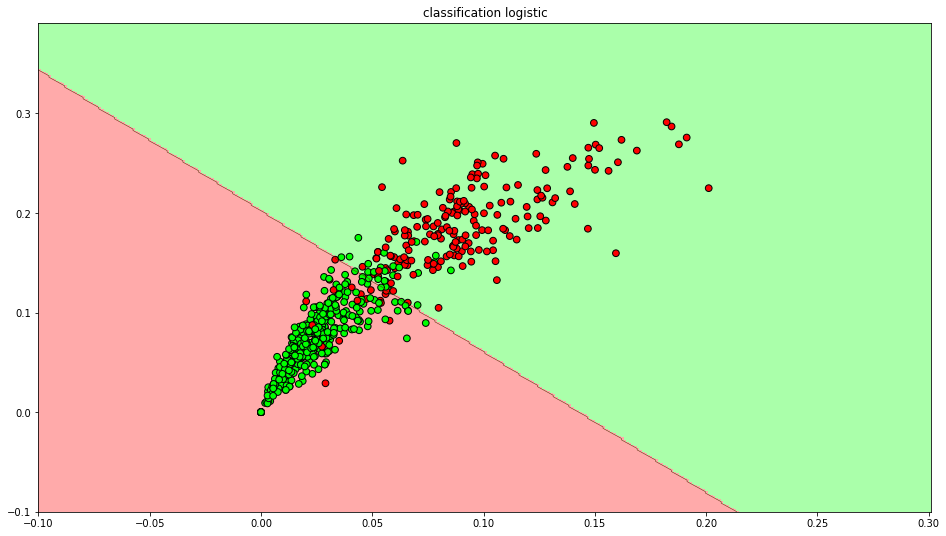

In [214]:
X['x2y2'] = (X['concpoints.mean']**2)*(X['concpoints.worst']**2)
X['xy'] = (X['concpoints.mean']**1)*(X['concpoints.worst']**1)
X['x3'] = X['concpoints.mean']**3

X = X[['concpoints.mean','concpoints.worst','xy','x3']]
x_train, x_test, y_train, y_test = train_test_split(X,y)

#log.fit(x_train,y_train)
log=LogisticRegression(C=1000,tol=1e-12,solver="lbfgs")

#log.fit(x_train, y_train)
log.fit(x_train, y_train)

# Plotting decision regions
x_min, x_max = X['concpoints.mean'].min() - 0.1, X['concpoints.mean'].max() + 0.1
y_min, y_max = X['concpoints.worst'].min() - 0.1, X['concpoints.worst'].max() + 0.1

z_min, z_max = X['xy'].min(), X['xy'].max()
u_min, u_max = X['x3'].min(), X['x3'].max()




xx, zz = np.meshgrid(np.linspace(x_min, x_max, 341),np.linspace(z_min, z_max, 341))

xx, uu = np.meshgrid(np.linspace(x_min, x_max, 341),np.linspace(u_min, u_max, 341))


Z = log.predict(np.c_[xx.ravel(), yy.ravel(), zz.ravel(), uu.ravel()])
z1 = Z.reshape(xx.shape)

print(accuracy_score(log.predict(x_test),y_test))

# Put the result into a color plot
plt.figure(figsize=(16,9))
plt.pcolormesh(xx, yy, z1, cmap=cmap_light)
plt.contour(xx,yy,z1, linewidths = 0.5, levels = 1, cmap = plt.cm.BrBG)
plt.scatter(X['concpoints.mean'], X['concpoints.worst'], c=y, cmap=cmap_bold, edgecolor='k', s=45)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("classification logistic")
plt.show()

Here, we tried three combinations of new features

* x2*y2,x3
* x3,xy
* x2*y2,xy

We are getting the same accuracy in the first and second cases and we can see the decision boundary moving between 0.15 and 0.25 in all the three cases. 



## 3. Use the full data

### 3.1 Cross Validation

In [45]:
def perform_kfolds_validation (data,nfolds,regularization_type,lambda_value):
    #Calculate length of input data and divide by number of folds
    nrows = len(data)
    set_nrows = nrows//nfolds
    
    #Make lists for the whole
    indexes = np.array(data.index)
    np.random.shuffle(indexes)
    accuracy_list = []
    precision_list = []
    recall_list = []
    fold_list = []
    #partition the dataset into nfolds -1 for training sets. Append each fold in the list
    for i in range(0,nfolds):
        #start index
        start_index = int(i*set_nrows)
        #end index
        end_index = int(start_index + set_nrows)
        
            
        test_indexes = indexes[start_index:end_index]
        
        test_data = data.loc[test_indexes,:]
        train_data = data.ix[~data.index.isin(test_indexes),:]
        
        train_x = train_data.drop('diagnosis',axis=1)
        train_y = train_data['diagnosis']
        test_x = test_data.drop('diagnosis',axis=1)
        test_y = test_data['diagnosis']

        log_model = LogisticRegression(C=1/lambda_value,penalty=regularization_type)
        log_model.fit(train_x,train_y)
        predictions = log_model.predict(test_x)
        accuracy = accuracy_score(test_y,predictions)
        accuracy_list.append(accuracy)
        prfs = precision_recall_fscore_support(test_y,predictions,average='macro')
        precision_list.append(prfs[0])
        recall_list.append(prfs[1])

    print("Training set size for each fold:",train_data.shape[0])
    print("Training set size for each fold:",test_data.shape[0])
    results['accuracy'] = accuracy_list
    results['precision'] = precision_list
    results['recall'] = recall_list
        
    return results

In [44]:
results = pd.DataFrame(columns=['accuracy','precision','recall'])
perform_kfolds_validation(data,10,'l1',0.001)

Training set size for each fold: 513
Training set size for each fold: 56


accuracy  precision    recall
0  0.928571   0.922222  0.922222
1  0.964286   0.959064  0.959064
2  0.946429   0.933855  0.945906
3  0.946429   0.945906  0.933855
4  0.982143   0.982759  0.982143
5  0.928571   0.929757  0.929757
6  1.000000   1.000000  1.000000
7  0.964286   0.959064  0.959064
8  0.982143   0.976190  0.986111
9  0.982143   0.987179  0.972222

#### 3.2 Regularization

#### 3.2.1 Type of regularization

#### 3.2.2 Regularization parameters

In [114]:
#Define list of lambda values
start = 1e-6
ratio = 10
n = 11
lambdavalues = [round(start * ratio**i,6) for i in range(n)]
lambdavalues

[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]

#### 3.2.3

In [129]:
def perform_kfolds_validation_mean (data,nfolds,regularization_type,lambda_value):
    nrows = len(data)
    set_nrows = nrows//nfolds
    indexes = np.array(data.index)
    np.random.shuffle(indexes)
    accuracy_list = []
    precision_list = []
    recall_list = []
    fold_list = []
    
    #For each fold, perform classification
    for fold in range(0,nfolds):
        #Define start and end index
        start_ind = int(fold*set_nrows)
        end_ind = int(start_ind + set_nrows)
        
        #Divide into test and train data
        test_indexes = indexes[start_ind:end_ind]
        test_data = data.loc[test_indexes,:]
        train_data = data.ix[~data.index.isin(test_indexes),:]
        
        #Divide classification labels and input data
        train_x = train_data.drop('diagnosis',axis=1)
        train_y = train_data['diagnosis']
        test_x = test_data.drop('diagnosis',axis=1)
        test_y = test_data['diagnosis']
        
        #Define model
        log_model = LogisticRegression(C=1/lambda_value,penalty=regularization_type)
        log_model.fit(train_x,train_y)
        predictions = log_model.predict(test_x)
        
        #Calculate metrics
        accuracy = accuracy_score(test_y,predictions)
        prfs = precision_recall_fscore_support(test_y,predictions,average='macro')
        
        #Store metrics
        accuracy_list.append(accuracy)
        precision_list.append(prfs[0])
        recall_list.append(prfs[1])
    
    #Calculate average of the metrics
    accuracy = np.mean(accuracy_list)*100
    precision = np.mean(precision_list)*100
    recall = np.mean(recall_list)*100
        
    return (lambda_value,accuracy,precision,recall,regularization_type)

#### Lasso Regression


In [138]:
column_list = ['Lambda',"accuracy","Precision","Recall","Regularization Type"]
lasso_performance_data = pd.DataFrame(columns=column_list)
for i in lambdavalues:
    acc = perform_kfolds_validation_mean(data,10,'l1',i)
    index = len(lasso_performance_data)+1
    lasso_performance_data.loc[index] = acc

c:\users\iguest\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [139]:
lasso_performance_data

Lambda   accuracy  Precision     Recall Regularization Type
1       0.000001  95.714286  95.274865  95.290654                  l1
2       0.000010  96.428571  96.319551  95.919487                  l1
3       0.000100  95.535714  95.097786  95.647125                  l1
4       0.001000  95.535714  95.265131  94.997109                  l1
5       0.010000  96.250000  96.244877  95.851823                  l1
6       0.100000  96.071429  95.721305  95.790769                  l1
7       1.000000  95.000000  94.630485  94.702157                  l1
8      10.000000  92.857143  92.723293  91.404365                  l1
9     100.000000  91.964286  92.441532  90.499068                  l1
10   1000.000000  91.428571  92.921888  89.101656                  l1
11  10000.000000  37.142857  18.571429  50.000000                  l1

#### Ridge Regression

In [289]:
column_list = ['Lambda',"accuracy","Precision","Recall","Regularization Type"]
ridge_performance_data = pd.DataFrame(columns=column_list)

for i in lambdavalues:
    acc = perform_kfolds_validation_mean(data,10,'l2',i)
    index = len(ridge_performance_data)+1
    ridge_performance_data.loc[index] = acc

In [290]:
ridge_performance_data

Lambda   accuracy  Precision     Recall Regularization Type
1       0.000001  95.892857  95.739509  95.632409                  l2
2       0.000010  96.071429  95.933186  95.781335                  l2
3       0.000100  95.714286  95.502187  95.419625                  l2
4       0.001000  95.357143  95.148484  95.223978                  l2
5       0.010000  95.357143  95.070925  94.730689                  l2
6       0.100000  95.892857  95.937205  95.095069                  l2
7       1.000000  95.357143  95.358442  94.819778                  l2
8      10.000000  94.642857  94.233723  93.803816                  l2
9     100.000000  93.035714  93.470275  91.654700                  l2
10   1000.000000  92.678571  93.139473  91.594964                  l2
11  10000.000000  91.964286  92.827555  90.134104                  l2

### 4. ROC Curve

#### 4.1 Split data

Split the data into a training set and testing set

In [253]:
#Define the output variable
y = data['diagnosis']
#defining the input parameters
X = data

#Remove output variable and id from input parameters dataframe
columns = list(X.columns)
columns.remove('diagnosis')
X = X[columns]

In [254]:
#Split into training and testing data
x_train, x_test, y_train, y_test = train_test_split(X,y,train_size=0.66)

#Scaled data for KNN
X.values
scaler = MinMaxScaler()
X2 = scaler.fit_transform(X)

x2_train, x2_test, y2_train, y2_test = train_test_split(X2,y,train_size=0.66)

#### 4.2 Models

Defining models for k-Nearest Neighbors, Naive Bayes and Logistic Regression and tuning their hyperparameters

In [255]:
#Naive Bayes
nb_model = GaussianNB()

#K Nearest Neighbours
knn_model_1 = KNeighborsClassifier(n_neighbors=1)
knn_model_2 = KNeighborsClassifier(n_neighbors=6)
knn_model_3 = KNeighborsClassifier(n_neighbors=16)

#Logistic Regression Model 
logit_model = LogisticRegression(solver='lbfgs',tol=1e-11,penalty='l2',C = 1/0.001)

#### 4.3 Predict Probabilities

Predicting probabilities of each model

In [256]:
nb_model.fit(x_train,y_train)
nb_prob = nb_model.predict_proba(x_test)

In [287]:
def rocfinder(model):
    nt = 10
    n = np.shape(y_test)[0]
    tpLog = []
    fpLog = []
    thresh = np.linspace(0, 0.9, nt)
    prob = model.predict_proba(x_test)[:,1]
    for i in thresh:
        tpLogt = sum(((prob >= i) == True) & (y_test == 1)) / sum(y_test)
        fpLogt = sum((prob >= i) & (y_test == 0)) / sum(y_test == 0)
        tpLog.append(tpLogt)
        fpLog.append(fpLogt)
        fig, ax = plt.subplots()
        ax.plot(fpLog, tpLog)  
    
    print("auc is",auc(fpLog, tpLog), "for threshhold = ", i)


auc is 0.9442779442779442 for threshhold =  0.9


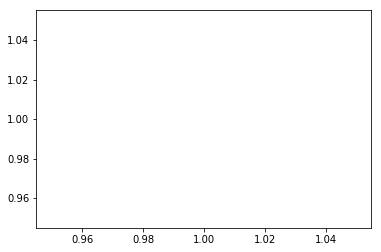

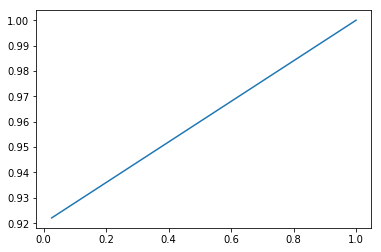

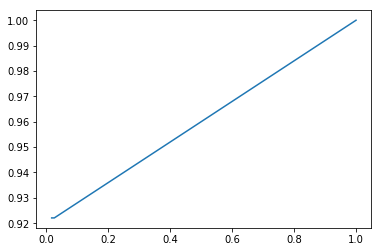

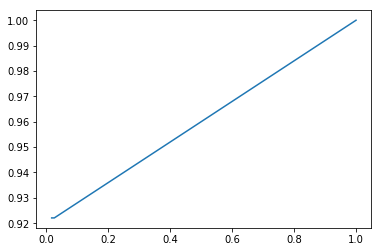

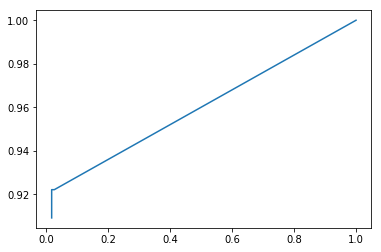

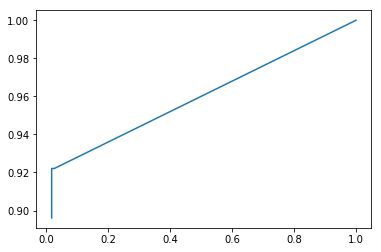

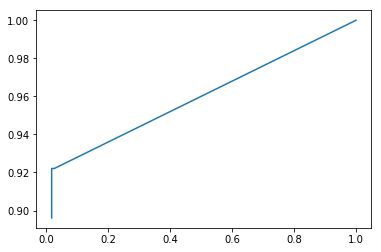

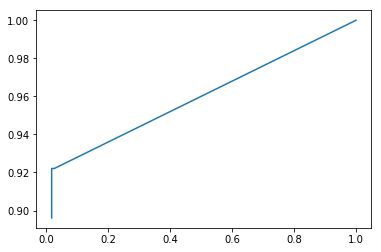

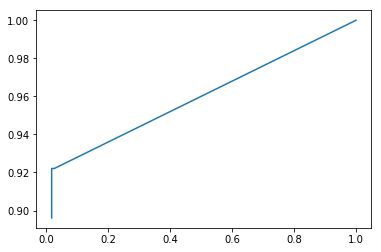

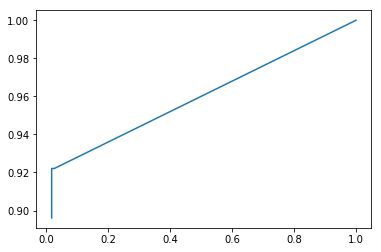

In [288]:
hatyLog = nb_model.predict_proba(x_test)[:,1]
rocfinder(nb_model)

auc is 0.9736374736374737 for threshhold =  0.9


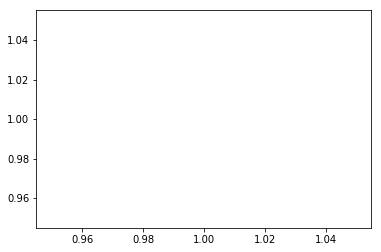

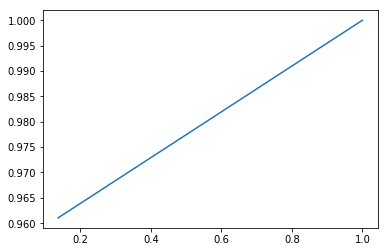

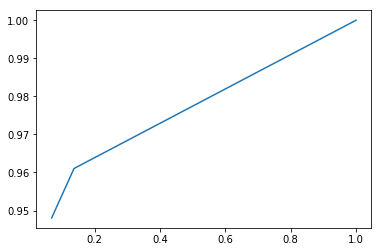

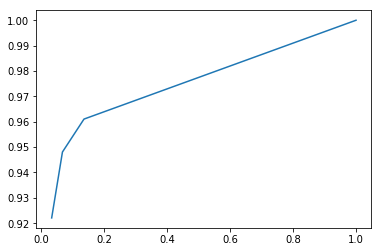

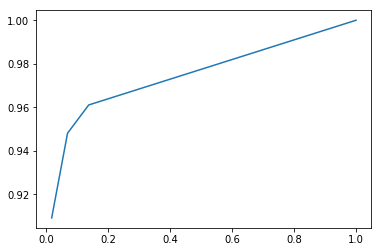

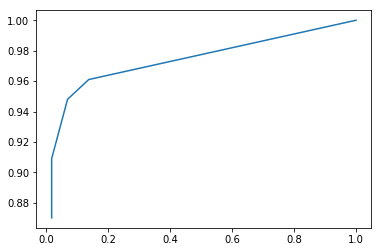

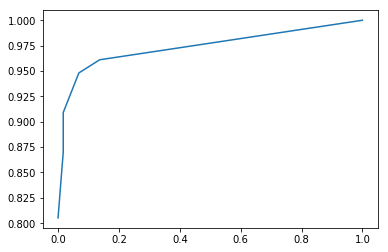

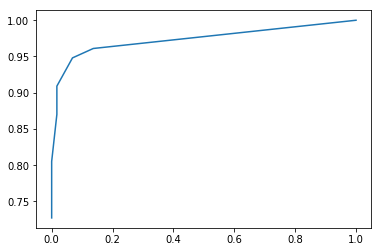

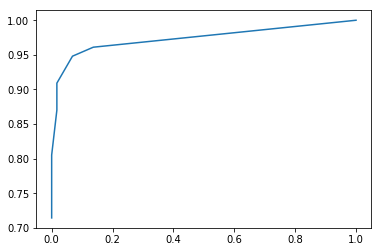

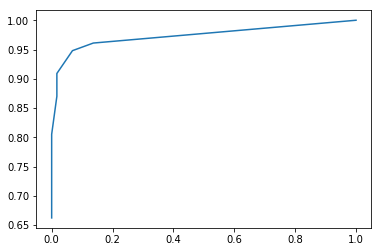

In [278]:
knn_model_1.fit(x2_train,y2_train)
rocfinder(knn_model_3)

auc is 0.9736374736374737 for threshhold =  0.9


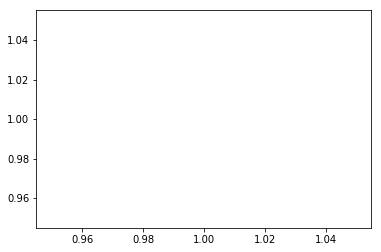

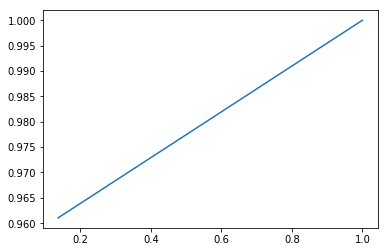

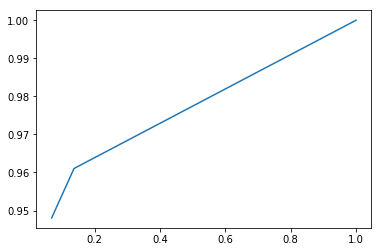

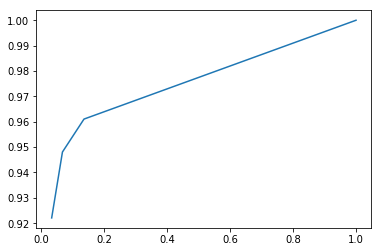

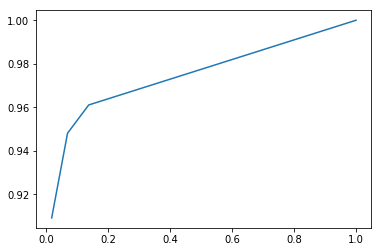

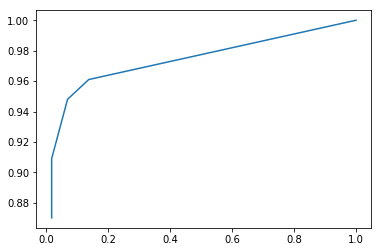

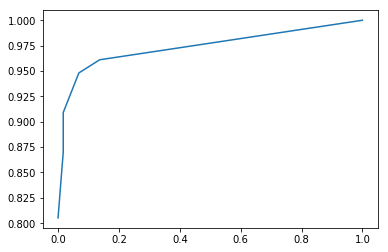

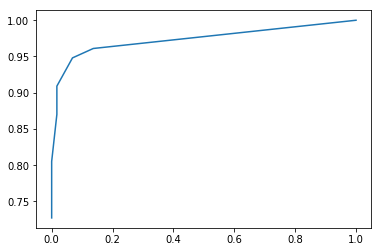

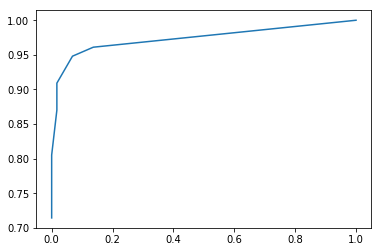

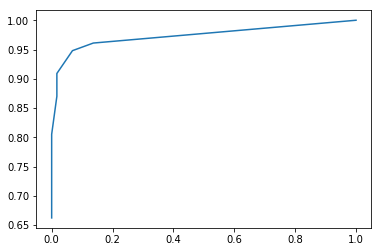

In [272]:
knn_model_2.fit(x_train,y_train)
rocfinder(knn_model_3)

auc is 0.9736374736374737 for threshhold =  0.9


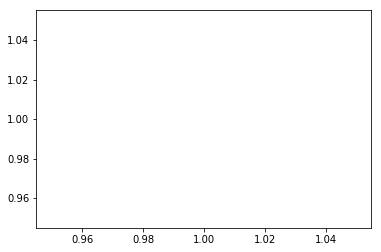

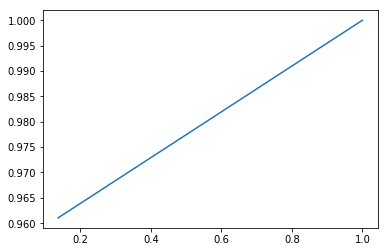

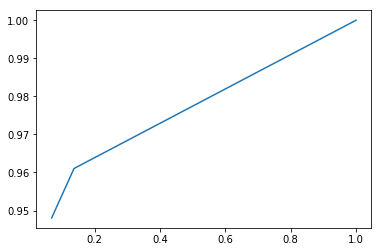

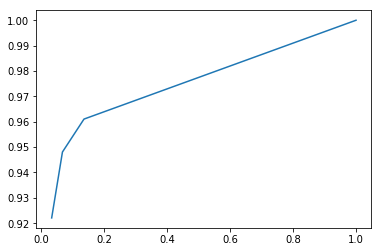

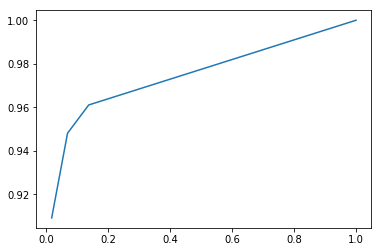

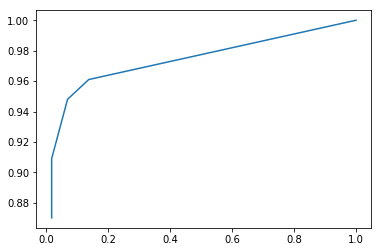

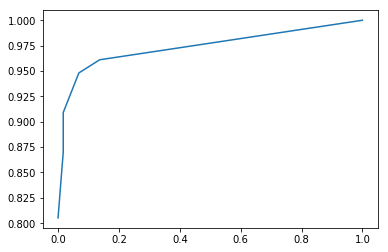

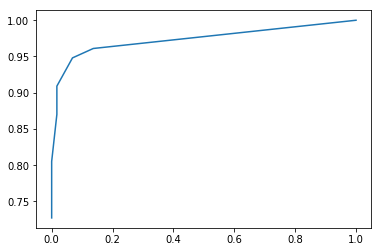

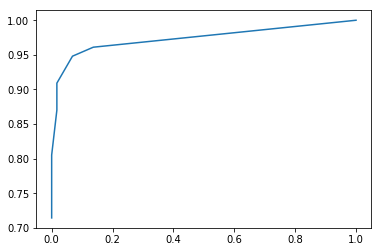

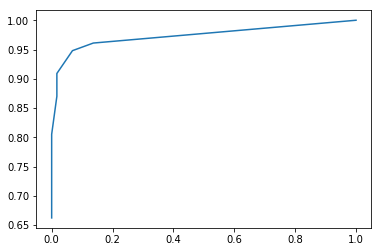

In [271]:
knn_model_3.fit(x_train,y_train)
rocfinder(knn_model_3)

auc is 0.9815739815739816 for threshhold =  0.9


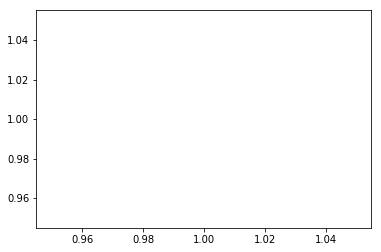

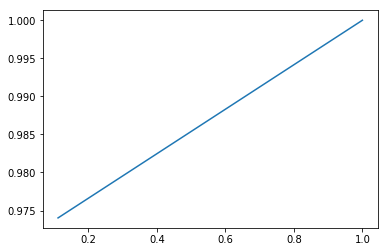

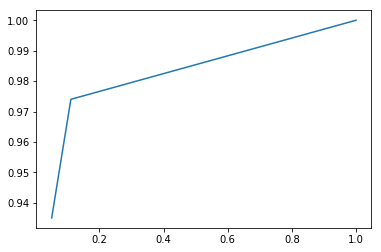

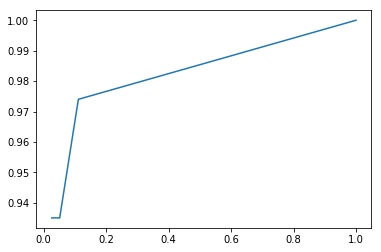

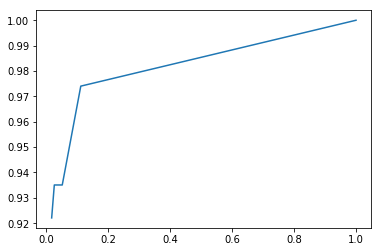

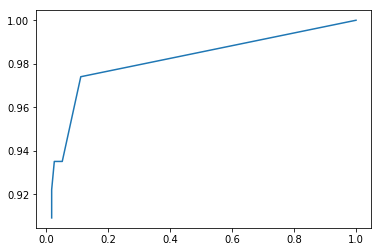

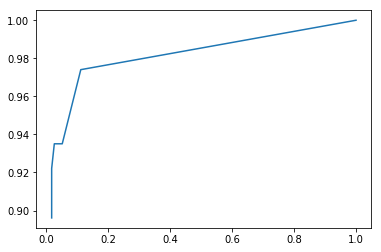

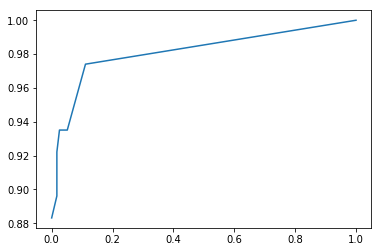

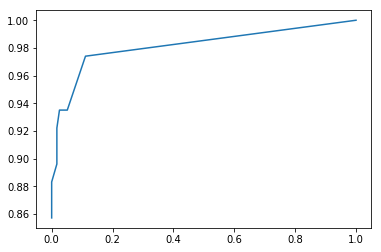

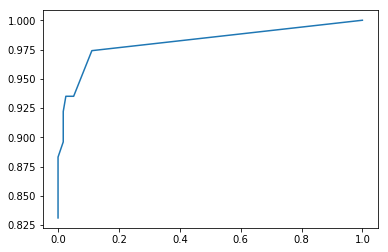

In [268]:
logit_model.fit(x_train,y_train)
rocfinder(logit_model)

#### Explanation

Best threshold value is 0.9. And the best model is Logistic Regression which gives accuracy of 98%